# PROJET 7 : IMPLÉMENTEZ UN MODÈLE DE SCORING

## Description du projet 

Une société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt. Elle souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées.

## Mission

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.


## 0 - PRÉALABLES :

### A - Importation des librairies :

In [130]:
# no warnings :
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [141]:
!python --version

Python 3.9.12


In [144]:
# basics :
import numpy as np
import pandas as pd
import re
import gc
import os
from contextlib import contextmanager
from math import pi

# models, model selection & metrics
from lightgbm import LGBMClassifier
from lightgbm import create_tree_digraph
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import shap

# Visualisation :
import matplotlib.pyplot as plt
import seaborn as sns

# Export
import joblib


from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from imblearn.pipeline import Pipeline as imbpipeline
from lime.lime_tabular import LimeTabularExplainer

from pickle import *

### B) Commentaires sur l'utilisation d'un Kernel Kaggle :
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

## I - FEATURES ENGINEERING (VIA KERNEL KAGGLE) :


### A - Préalables :

#### 1) Définition du répertoire :

In [225]:
# Direction du répertoire
path = "/Users/felixganga/Documents/OpenClass_Data/P7_GANGA_felix/"

In [226]:
#Liste des fichiers

PATH="data/"
print("LISTE DES FICHIERS :")
display(os.listdir(path))

LISTE DES FICHIERS :


['application_test.csv',
 '.DS_Store',
 'test_df.csv',
 'Untitled.ipynb',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'data.csv',
 'bureau.csv',
 '.ipynb_checkpoints',
 'LGBM_model_kernel',
 'previous_application.csv',
 'test.ipynb',
 'bureau_balance.csv',
 'sample_submission.csv']

In [227]:
#Chargement des données
application_train = pd.read_csv(path+"/application_train.csv")
application_test = pd.read_csv(path+"/application_test.csv")
bureau = pd.read_csv(path+"/bureau.csv")
bureau_balance = pd.read_csv(path+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(path+"/credit_card_balance.csv")
installments_payments = pd.read_csv(path+"/installments_payments.csv")
POS_CASH_balance = pd.read_csv(path+"/POS_CASH_balance.csv")
previous_application = pd.read_csv(path+"/previous_application.csv")

In [228]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
application_train.shape

(307511, 122)

In [230]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [231]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [232]:
bureau.shape

(1716428, 17)

In [233]:
bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [234]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [235]:
bureau_balance.shape

(27299925, 3)

In [236]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [237]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [238]:
installments_payments.shape

(13605401, 8)

In [239]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [240]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [241]:
POS_CASH_balance.shape

(10001358, 8)

In [242]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [243]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
previous_application.shape

(1670214, 37)

In [245]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [246]:
def describe_dataset(source_files):
    '''
        Outputs a presentation pandas dataframe for the dataset.
        Parameters
        ----------------
        sourceFiles     : dict with :
                            - keys : the names of the files
                            - values : the dataframe for the data
    
        Returns
        ---------------
        presentation_df : pandas dataframe :
                            - a column "Nom du fichier" : the name of the file
                            - a column "Nb de lignes"   : the number of rows per file
                            - a column "Nb de colonnes" : the number of columns per file
    '''

    print("Les données se décomposent en {} fichier(s): \n".format(len(source_files)))

    filenames = []
    files_nb_lines = []
    files_nb_columns = []
    nan_percent = []
    duplicate_percent = []

    for filename, file_data in source_files.items():
        filenames.append(filename)
        files_nb_lines.append(len(file_data))
        files_nb_columns.append(len(file_data.columns))
        nan_percent.append(round(file_data.isna().sum().sum()/file_data.size*100, 2))
        duplicate_percent.append(round(file_data.duplicated().sum().sum()/file_data.size*100, 2))

                           
    # Create a dataframe for presentation purposes
    presentation_df = pd.DataFrame({'Nom du fichier':filenames,
                                    'Nb de lignes':files_nb_lines,
                                    'Nb de colonnes':files_nb_columns,
                                    '%NaN' :nan_percent,
                                    '%Duplicate' :duplicate_percent})

    presentation_df.index += 1

    return presentation_df


In [247]:
describe_dataset({'Application Train': application_train,
                  'Application Test': application_test, 
                  'Bureau': bureau,
                  'Bureau Balance': bureau_balance,
                  'Credit Card Balance' : credit_card_balance,
                  'Installments Payments': installments_payments,
                  'POS CASH balance': POS_CASH_balance,
                  'Previous Application': previous_application})

Les données se décomposent en 8 fichier(s): 



,Nom du fichier,Nb de lignes,Nb de colonnes,%NaN,%Duplicate
1,Application Train,307511,122,24.40,0.0
2,Application Test,48744,121,23.81,0.0
3,Bureau,1716428,17,13.50,0.0
4,Bureau Balance,27299925,3,0.00,0.0
5,Credit Card Balance,3840312,23,6.65,0.0
6,Installments Payments,13605401,8,0.01,0.0
7,POS CASH balance,10001358,8,0.07,0.0
8,Previous Application,1670214,37,17.98,0.0


#### 2) Fonction d'encodage " one hot encoder ":

In [248]:
# Fonction d'encodage :
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### B - Import et traitement des fichiers (via un kernel Kaggle) :

#### 1) "application_train  " & "application_test"

In [249]:
# Importation et transformation de application_train et application_test :
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path + "application_train.csv", nrows= num_rows)
    test_df = pd.read_csv(path + "application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

#### 2) "bureau" & "bureau_balance" :

In [250]:
# Importation et transformation de bureau et bureau_balance :
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + "bureau.csv", nrows = num_rows)
    bb = pd.read_csv(path + "bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

#### 3) "previous_applications" :

In [251]:
# Importation et transformation de bureau et bureau_balance :
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + "previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


#### 4) "POS_CASH_balance" :

In [252]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + "POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

#### 5) "installments_payments" :

In [253]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + "installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

#### 6) "credit_card_balance" :

In [254]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + "credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

#### 7) Jointures des différents dataframes :

In [255]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [256]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
 
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()

    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()

    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

    #feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

    df = df.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    df.to_csv("data.csv")
    
    return df



In [257]:
data= main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


In [258]:
df = pd.read_csv('data.csv')

In [259]:
df.head()

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
def valeur_manquante(data):
    nb_rows=data.shape[0]
    ret=pd.DataFrame(data.isna().sum(),columns=['nb_manquant'])
    ret['pourcentage']=(ret['nb_manquant']/nb_rows)*100
    return ret

In [350]:
valeur_manquante(df).sort_values("pourcentage", ascending=False).head(20)

,nb_manquant,pourcentage
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.234287
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.234287
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.234287
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.234287
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.234287
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.234287
REFUSED_APP_CREDIT_PERC_VAR,298034,83.658432
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.901249
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,284559,79.875986
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,284559,79.875986


In [ ]:
def is_outlier(df,liste):
    '''Function that tranforms outliers into missing values.
    ----------
    Parameters:
               df: dataframe
               liste: list of features
    Returns:
            df: dataframe cleaned.
    '''
    for i in liste:
        q1 = df[i].quantile(.25)
        q3 = df[i].quantile(.75)
        iq_range = q3 - q1
        mask = df[i] > (q3 + (1.5* iq_range))
        df.loc[mask,i]= np.NaN
        mask2 = df[i] < (q1 - (1.5* iq_range))
        df.loc[mask2,i] = np.NaN
    return df

### Imputation des valeurs manquantes

In [314]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)

In [321]:
# Fit on the training data
clean_df=df.copy()
clean_df[clean_df==np.inf] = np.nan
imputer.fit(clean_df)

SimpleImputer(strategy='median', verbose=0)

In [322]:
clean_df.iloc[:,:] = imputer.transform(clean_df)

In [323]:
clean_df

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0.0,0.0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,1.0,1.0,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,2.0,2.0,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,3.0,3.0,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4.0,4.0,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,356250.0,48739.0,456221.0,0.0,1.0,0.0,0.0,0.0,121500.0,412560.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
356247,356251.0,48740.0,456222.0,0.0,1.0,0.0,1.0,2.0,157500.0,622413.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
356248,356252.0,48741.0,456223.0,0.0,1.0,1.0,0.0,1.0,202500.0,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
356249,356253.0,48742.0,456224.0,0.0,0.0,0.0,1.0,0.0,225000.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


# Outliers, valeurs atypiques, anormales

## Distribution de certaines features d'intérêt

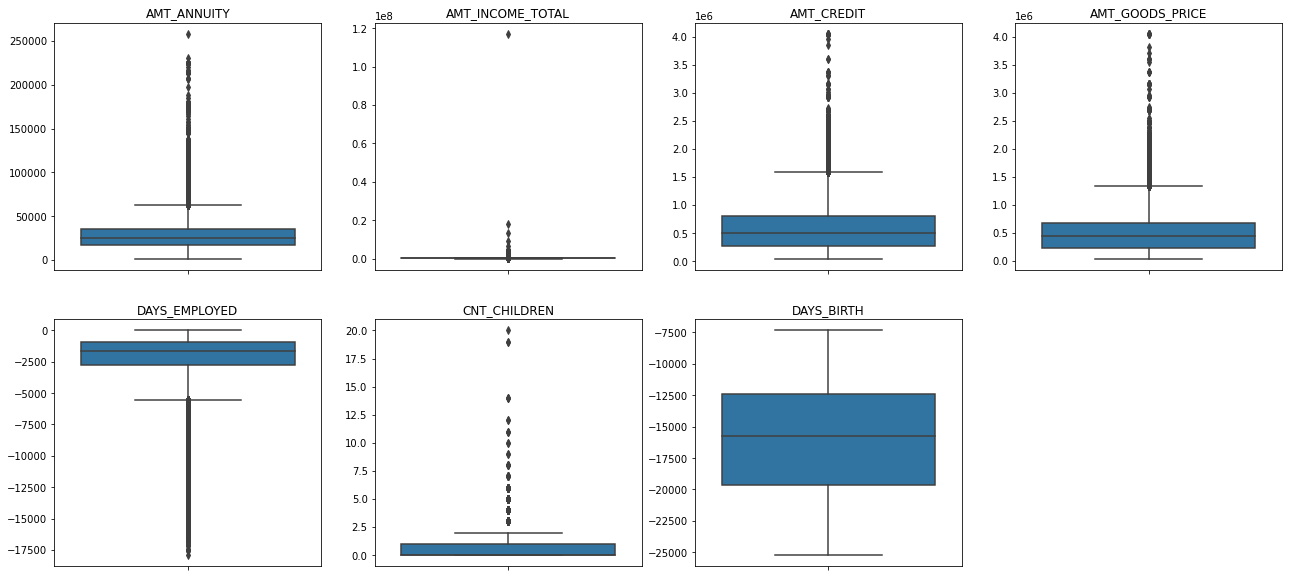

In [339]:
plt.figure(figsize=(22,10))

app_outlier_col_1 = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_EMPLOYED']
app_outlier_col_2 = ['CNT_CHILDREN','DAYS_BIRTH']
for i in enumerate(app_outlier_col_1):
    plt.subplot(2,4,i[0]+1)
    sns.boxplot(y=clean_df[i[1]])
    plt.title(i[1])
    plt.ylabel("")

for i in enumerate(app_outlier_col_2):
    plt.subplot(2,4,i[0]+6)
    sns.boxplot(y=clean_df[i[1]])
    plt.title(i[1])
    plt.ylabel("")

In [346]:
clean_df[['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_EMPLOYED','CNT_CHILDREN','DAYS_BIRTH']].describe()

,AMT_ANNUITY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,CNT_CHILDREN,DAYS_BIRTH
count,356251.000000,3.562510e+05,3.562510e+05,3.562510e+05,356251.000000,356251.000000,356251.000000
mean,27425.407206,1.701159e+05,5.877695e+05,5.279603e+05,-2263.537363,0.414312,-16041.276687
std,14732.135422,2.235080e+05,3.986253e+05,3.659293e+05,2130.887166,0.720376,4358.798530
min,1615.500000,2.565000e+04,4.500000e+04,4.050000e+04,-17912.000000,0.000000,-25229.000000
25%,16731.000000,1.125000e+05,2.700000e+05,2.340000e+05,-2781.000000,0.000000,-19676.000000
50%,25078.500000,1.530000e+05,5.002110e+05,4.500000e+05,-1663.000000,0.000000,-15755.000000
75%,34960.500000,2.025000e+05,7.975575e+05,6.750000e+05,-949.000000,1.000000,-12425.000000
max,258025.500000,1.170000e+08,4.050000e+06,4.050000e+06,0.000000,20.000000,-7338.000000


- AMT_ANNUITY, AMT_CREDIT, AMT_GOODS_PRICE, CNT_CHILDREN ont un certain nombre de valeurs aberrantes.

- AMT_INCOME_TOTAL a un grand nombre de valeurs aberrantes qui indiquent que quelques demandeurs de prêt ont un revenu élevé par rapport aux autres.

- DAYS_BIRTH n'a pas de valeurs aberrantes, ce qui signifie que les données disponibles sont fiables.

- DAYS_EMPLOYED a des valeurs aberrantes autour de 17500(jours)

### TARGET : statut de remboursement du prêt

- la valeur 0 signifie que le prêt est remboursé
- la valeur 1 signifie que le prêt n'est pas remboursé.

In [352]:
Imbalance = clean_df["TARGET"].value_counts().reset_index()
total=(Imbalance["TARGET"].sum())
Imbalance['pourcentage']=(Imbalance["TARGET"]/total)*100

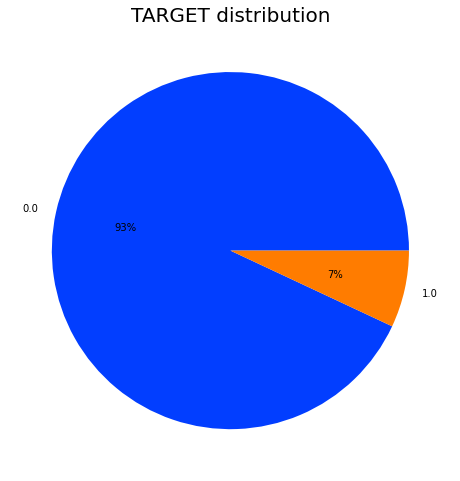

In [427]:
comptage_target = clean_df['TARGET'].value_counts()
colors = sns.color_palette('bright')
plt.figure(figsize=(8, 10))
plt.pie(comptage_target.values, labels=comptage_target.index,colors = colors, autopct = '%0.0f%%')
title=plt.title("TARGET distribution" , fontsize=20)

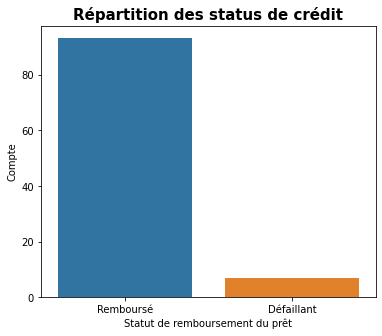

In [353]:
from matplotlib.pyplot import figure
plt.figure(figsize=(6,5))
x= ['Remboursé','Défaillant']
ax=sns.barplot(x,y="pourcentage",data=Imbalance)
plt.xlabel("Statut de remboursement du prêt")
plt.ylabel("Compte")
plt.title("Répartition des status de crédit",fontsize=15, fontweight='bold')
plt.show()

- La majorité des clients remboursent leur crédit.
- Cette variable étant la variable d'intérêt principale, nous seront en face d'un problème de classification     binaire déséquilibrée

In [351]:
# function for plotting repetitive countplots in univariate categorical analysis on applicationDF
# This function will create two subplots: 
# 1. Count plot of categorical column w.r.t TARGET; 
# 2. Percentage of defaulters within column

def univariate_categorical(applicationDF,feature,titre,ylog=False,label_rotation=False,
                           horizontal_layout=True):
    temp = applicationDF[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = applicationDF[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc["TARGET"] = cat_perc["TARGET"]*100
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,24))
        
    # 1. Subplot 1: Count plot of categorical column
    # sns.set_palette("Set2")
    s = sns.countplot(ax=ax1, 
                    x = feature, 
                    data=applicationDF,
                    hue ="TARGET",
                    order=cat_perc[feature],
                    palette=['g','r'])
        
    # Define common styling
    ax1.set_title(titre, fontdict={'fontsize' : 15, 'fontweight' : 'bold'}) 
    ax1.legend(['Remboursé','Défaillant'])
    
    # If the plot is not readable, use the log scale.
    if ylog:
        ax1.set_yscale('log')
        ax1.set_ylabel("Count (log)",fontdict={'fontsize' : 15, 'fontweight' : 'bold'})   
    
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    # 2. Subplot 2: Percentage of defaulters within the categorical column
    s = sns.barplot(ax=ax2, 
                    x = feature, 
                    y='TARGET', 
                    order=cat_perc[feature], 
                    data=cat_perc,
                    palette='Set2')
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Pourcentage de défaillants [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_title(titre+" (% Défaillants)", fontdict={'fontsize' : 15, 'fontweight' : 'bold'}) 

    plt.show();

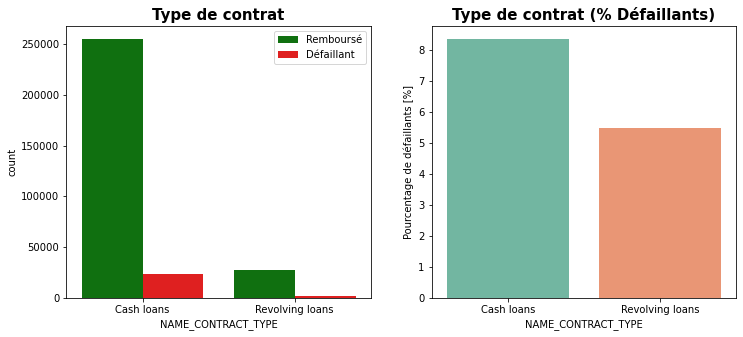

In [357]:
# Vérification du type de contrat en fonction 
# de l'état de remboursement du prêt
univariate_categorical(application_train , 'NAME_CONTRACT_TYPE', "Type de contrat")

Les prêts renouvelables ne représentent qu'une petite fraction (10 %) du nombre total de prêts ; dans le même temps, un plus grand nombre de prêts renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

### CODE_GENDER : genre

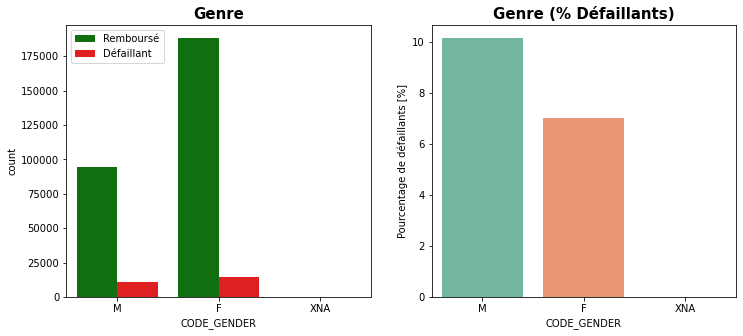

In [359]:
# Distribution du genre en fonction 
# de l'état de remboursement du prêt

univariate_categorical(application_train, 'CODE_GENDER', "Genre")

Le nombre de clients féminins est presque le double du nombre de clients masculins. Sur la base du pourcentage de crédits en défaut, les hommes ont plus de chances de ne pas rembourser leurs prêts (~ 10 %), par rapport aux femmes (~ 7 %)

### FLAG_OWN_CAR : indication sur la possession d'un véhicule

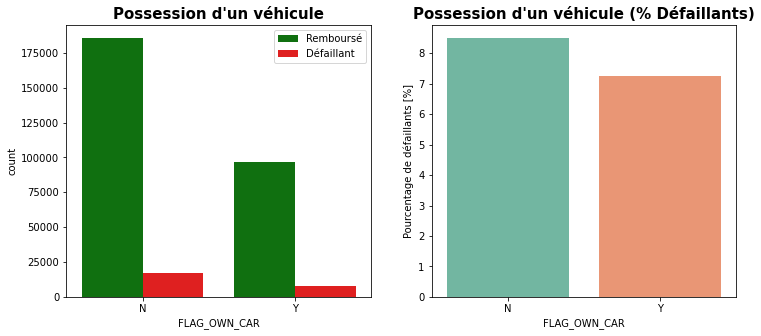

In [360]:
# Analyse de l'impact de la possession d'un véhicule  
# sur de l'état de remboursement du prêt

univariate_categorical(application_train, 'FLAG_OWN_CAR', "Possession d'un véhicule")

Les clients qui possèdent une voiture sont la moitié en nombre des clients qui ne possèdent pas de voiture. Mais sur la base du pourcentage de défaut, il n'y a pas de corrélation entre la possession d'une voiture et le remboursement du prêt car dans les deux cas, le pourcentage de défaut est presque le même.

### FLAG_OWN_REALTY : indication sur la possession d'un bien immobilier

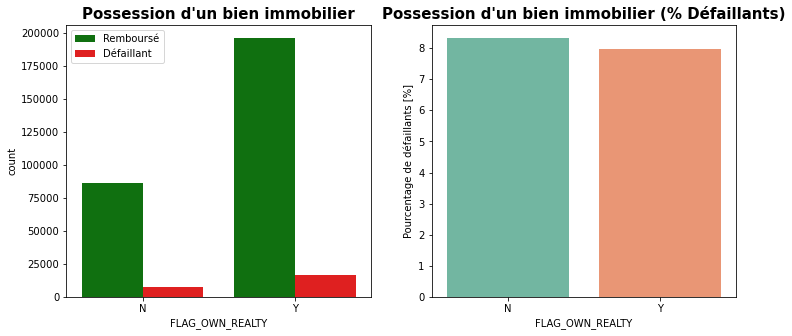

In [361]:
# Analyse de l'impact de la possession d'un bien immobilier  
# sur de l'état de remboursement du prêt

univariate_categorical(application_train, 'FLAG_OWN_REALTY', "Possession d'un bien immobilier")

Les clients qui possèdent des biens immobiliers sont plus du double de ceux qui ne sont pas propriétaires. Mais le taux de défaut des deux catégories est à peu près le même (~8%). Ainsi, il n'y a pas de corrélation entre la possession d'un bien immobilier et le défaut de paiement du prêt.

### NAME_FAMILY_STATUS : statut familial

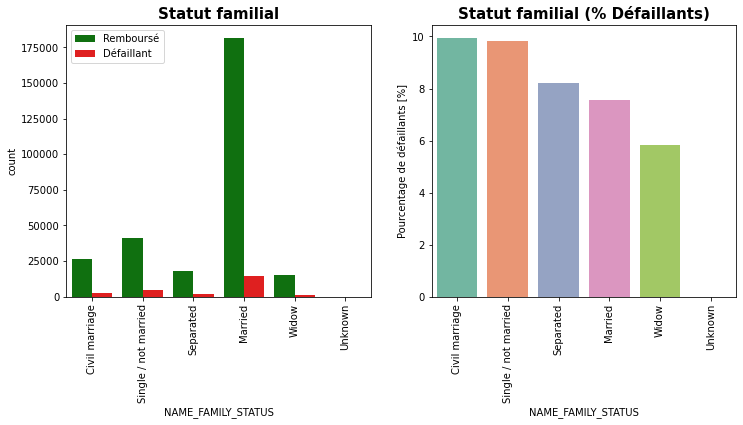

In [363]:
# Analyse de l'impact du statut familial
# sur de l'état de remboursement du prêt

univariate_categorical(application_train, 'NAME_FAMILY_STATUS', "Statut familial", False,True,True)

- La plupart des personnes qui ont contracté un prêt sont mariées, suivies par les célibataires/non mariés et le mariage civil
- En termes de pourcentage de non-remboursement de prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10 %), le statut de veuf(ve) eyant le plus faible taux de non-remboursement (l'exception étant inconnue).

### NAME_EDUCATION_TYPE : niveau d'éducation

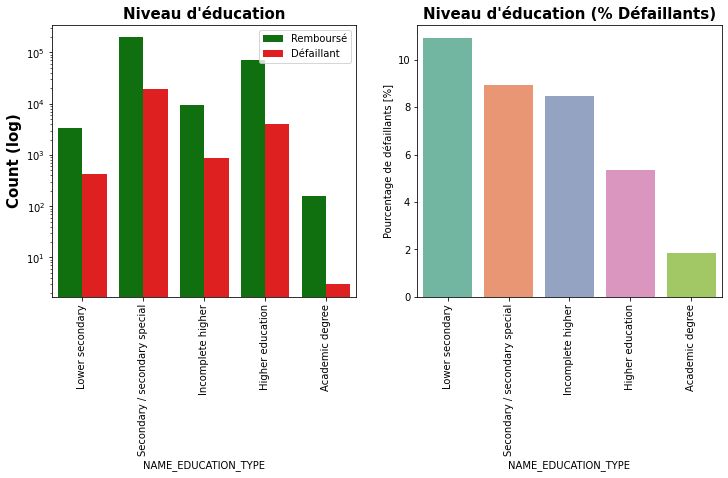

In [364]:
# Analyse de l'impact du niveau d'éducation
# sur de l'état de remboursement du prêt

univariate_categorical(application_train, 'NAME_EDUCATION_TYPE', "Niveau d'éducation", True,True,True)

- La majorité des clients ont une éducation de niveau secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

- La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

### NAME_INCOME_TYPE : type de revenu

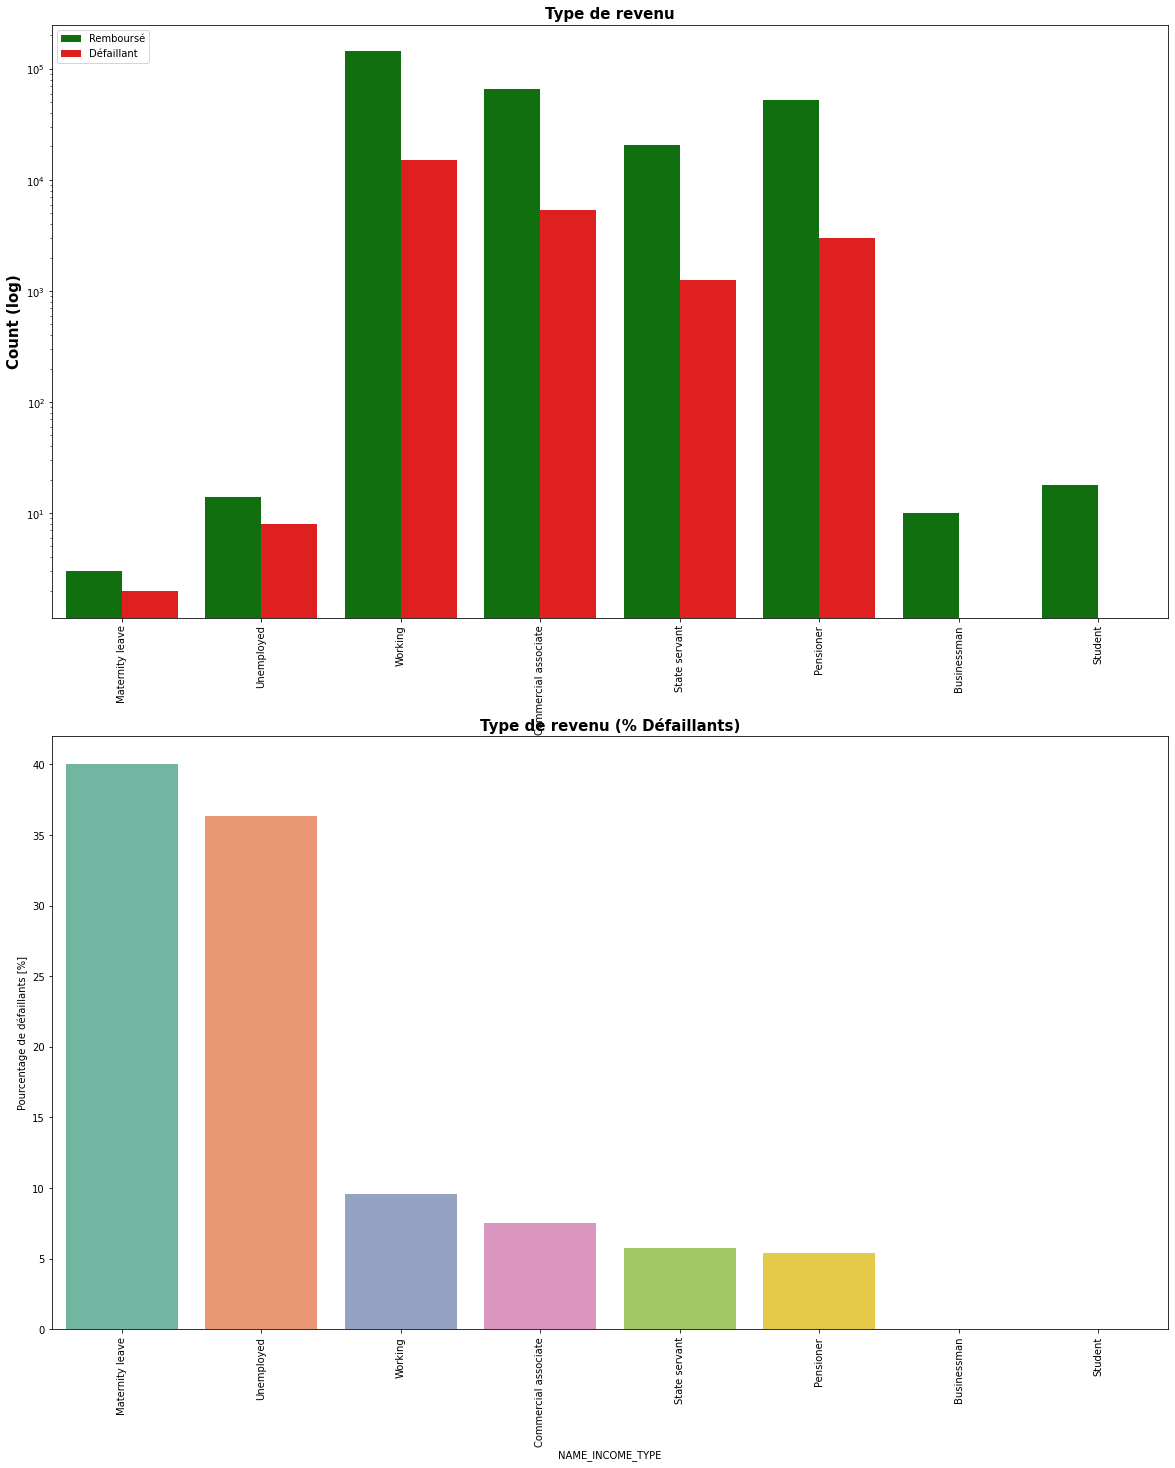

In [365]:
# Analyse de l'impact du type de revenu
# sur de l'état de remboursement du prêt

univariate_categorical(application_train, 'NAME_INCOME_TYPE', "Type de revenu", True,True,False)

- La plupart des demandeurs de prêts ont pour type de revenu le travail, suivi par les associés commerciaux, les retraités et les fonctionnaires.
- Les demandeurs ayant un revenu de type congé de maternité ont un taux de non-retour de près de 40 %, suivis par les chômeurs (37 %). Les autres types de revenus se situent en dessous de la moyenne de 10% de non remboursement des prêts.
- Les étudiants et les hommes d'affaires, bien que moins nombreux, n'ont pas de cas de défaut de paiement. Ces deux catégories sont donc les plus sûres pour l'octroi de prêts.

### OCCUPATION_TYPE : type de profession

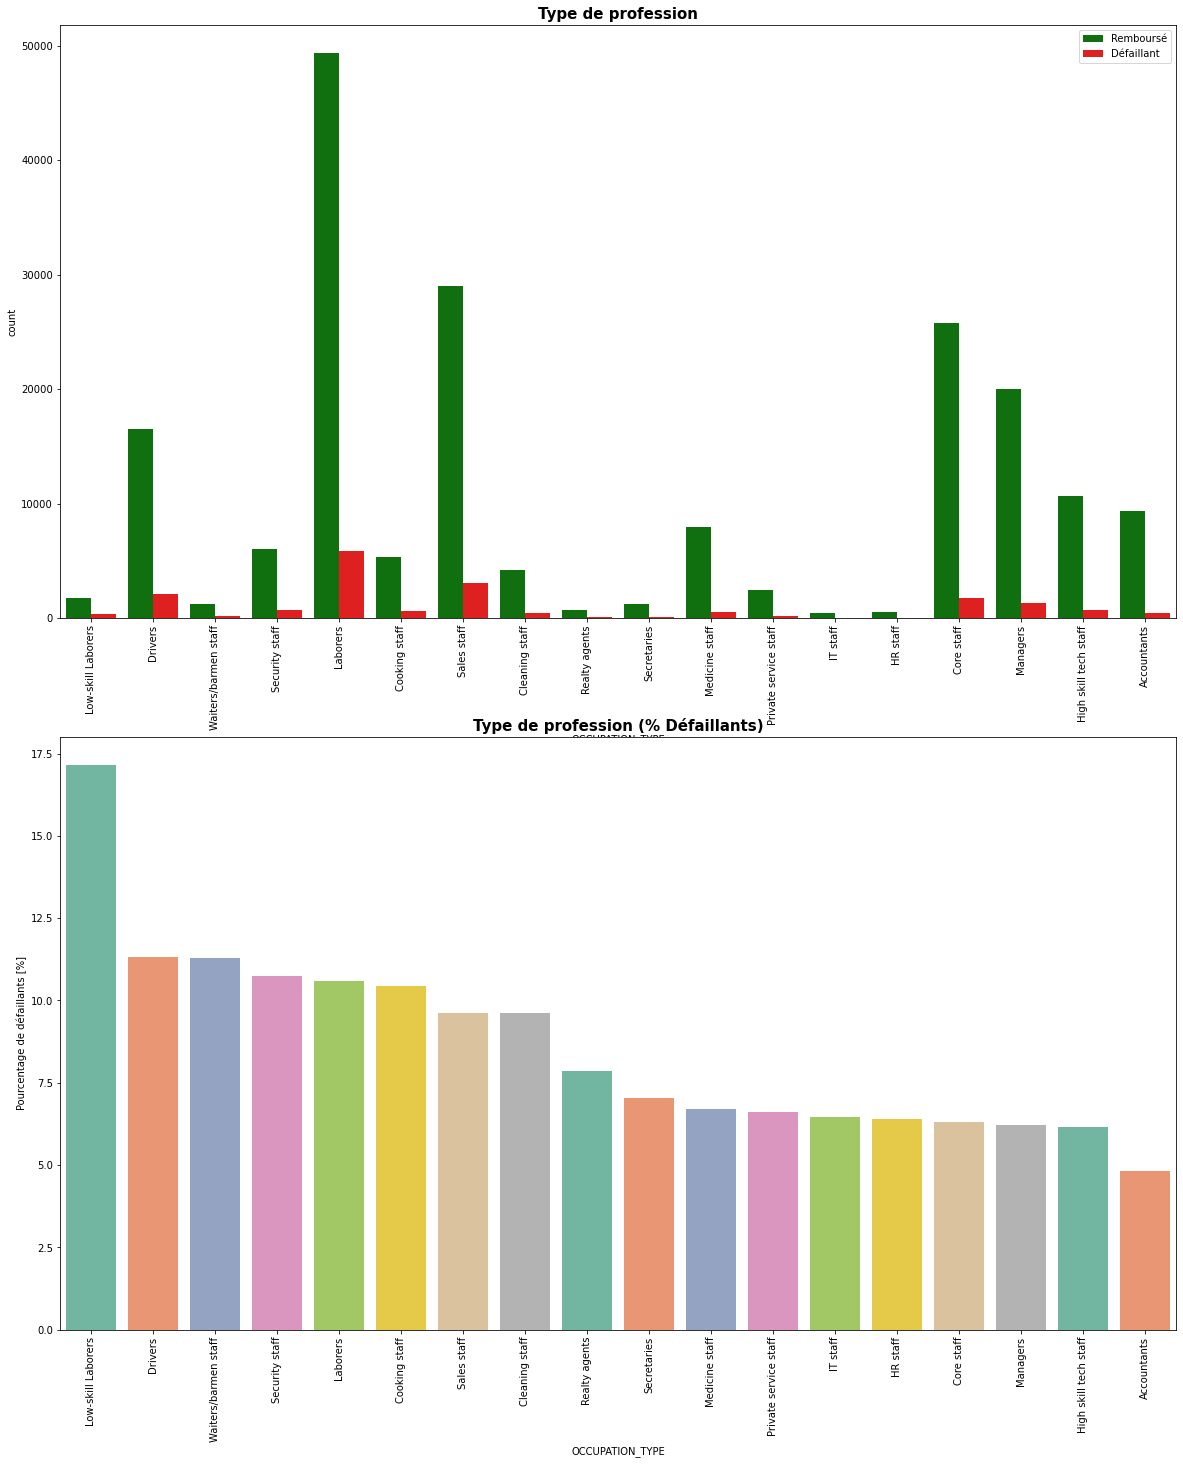

In [366]:
# Analyse de l'impact du type de profession
# sur de l'état de remboursement du prêt

univariate_categorical(application_train, 'OCCUPATION_TYPE', "Type de profession", False,True,False)

- La plupart des prêts sont contractés par des ouvriers, suivis par le personnel de vente. Les informaticiens sont ceux qui empruntent le moins.
- La catégorie présentant le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivie des chauffeurs et des serveurs/barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

### CNT_CHILDREN : Nombre d'enfants

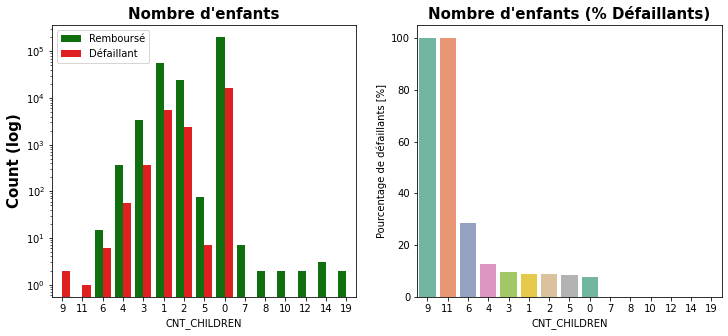

In [367]:
univariate_categorical(application_train, 'CNT_CHILDREN', "Nombre d'enfants", True)

- La plupart des demandeurs n'ont pas d'enfants

- Très peu de clients ont plus de 3 enfants.

- Les clients qui ont plus de 4 enfants ont un taux de défaillance très élevé, ceux ayant 9 et 11 enfants présentant un taux de défaillance de 100%.

### DAYS_BIRTH (AGE_GROUP) : Age

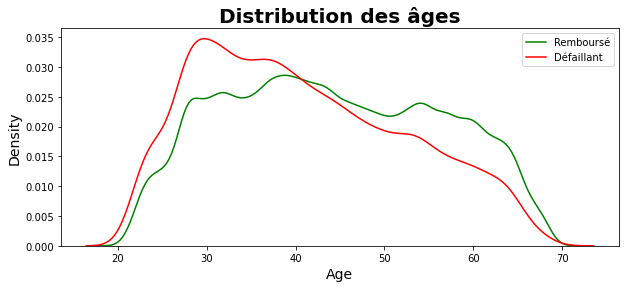

In [368]:
# Analyse de l'impact de l'âge
# sur de l'état de remboursement du prêt

plt.figure(figsize = (10, 4))
sns.kdeplot(clean_df[clean_df['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'Remboursé', color='g')
sns.kdeplot(clean_df[clean_df['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'Défaillant', color='r')

plt.legend()
plt.xlabel('Age',fontsize='14')
plt.ylabel('Density',fontsize='14')
plt.title('Distribution des âges', fontsize='20', fontweight='bold')
plt.show()

In [369]:
# Creating bins for Age
applicationDF = clean_df.copy()

applicationDF['AGE'] = applicationDF['DAYS_BIRTH'] // -365
bins = [0,20,30,40,50,100]
slots = ['0-20','20-30','30-40','40-50','50 above']

applicationDF['AGE_GROUP']=pd.cut(applicationDF['AGE'],bins=bins,labels=slots)

In [370]:
applicationDF['AGE_GROUP'].value_counts(normalize=True)*100

50 above    31.564824
30-40       27.054240
40-50       24.299160
20-30       17.080654
0-20         0.001123
Name: AGE_GROUP, dtype: float64

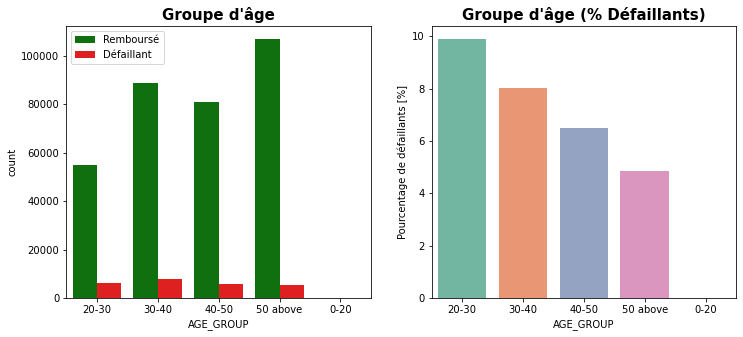

In [371]:
univariate_categorical(applicationDF, 'AGE_GROUP', "Groupe d'âge", False,False,True)

- Les personnes de la tranche d'âge 20-40 ans ont une probabilité plus élevée de défaillance.

- Les personnes âgées de plus de 50 ans ont une faible probabilité de défaillance.

### AMT_CREDIT (AMT_CREDIT_RANGE) : Montant du crédit du prêt

In [375]:
def plot_distribution(applicationDF,feature, title):
    plt.figure(figsize = (10, 4))

    t0 = applicationDF.loc[applicationDF['TARGET'] == 0]
    t1 = applicationDF.loc[applicationDF['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), label = 'Remboursé', color='g')
    sns.kdeplot(t1[feature].dropna(), label = 'Défaillant', color='r')
    plt.title(title, fontsize='20', fontweight='bold')
    #plt.ylabel('Density',fontsize='14')
    #plt.xlabel(fontsize='14')
    plt.legend()
    plt.show()   

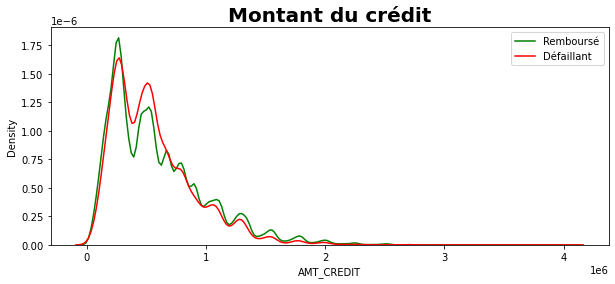

In [376]:
# Analyse de l'impact du montant du crédit
# sur de l'état de remboursement du prêt
plot_distribution(clean_df,'AMT_CREDIT', "Montant du crédit")

In [377]:
# Creating bins for Credit amount
applicationDF['AMT_CREDIT']=applicationDF['AMT_CREDIT']/100000

bins = [0,1,2,3,4,5,6,7,8,9,10,100]
slots = ['0-100K','100K-200K', '200k-300k','300k-400k','400k-500k','500k-600k','600k-700k','700k-800k',
       '800k-900k','900k-1M', '1M Above']

applicationDF['AMT_CREDIT_RANGE']=pd.cut(applicationDF['AMT_CREDIT'],bins=bins,labels=slots)

In [378]:
#checking the binning of data and % of data in each category
applicationDF['AMT_CREDIT_RANGE'].value_counts(normalize=True)*100

200k-300k    17.992651
1M Above     15.315606
500k-600k    11.226635
400k-500k    10.805022
100K-200K     9.973025
300k-400k     8.979343
600k-700k     7.819206
800k-900k     6.777244
700k-800k     6.152404
900k-1M       2.803922
0-100K        2.154941
Name: AMT_CREDIT_RANGE, dtype: float64

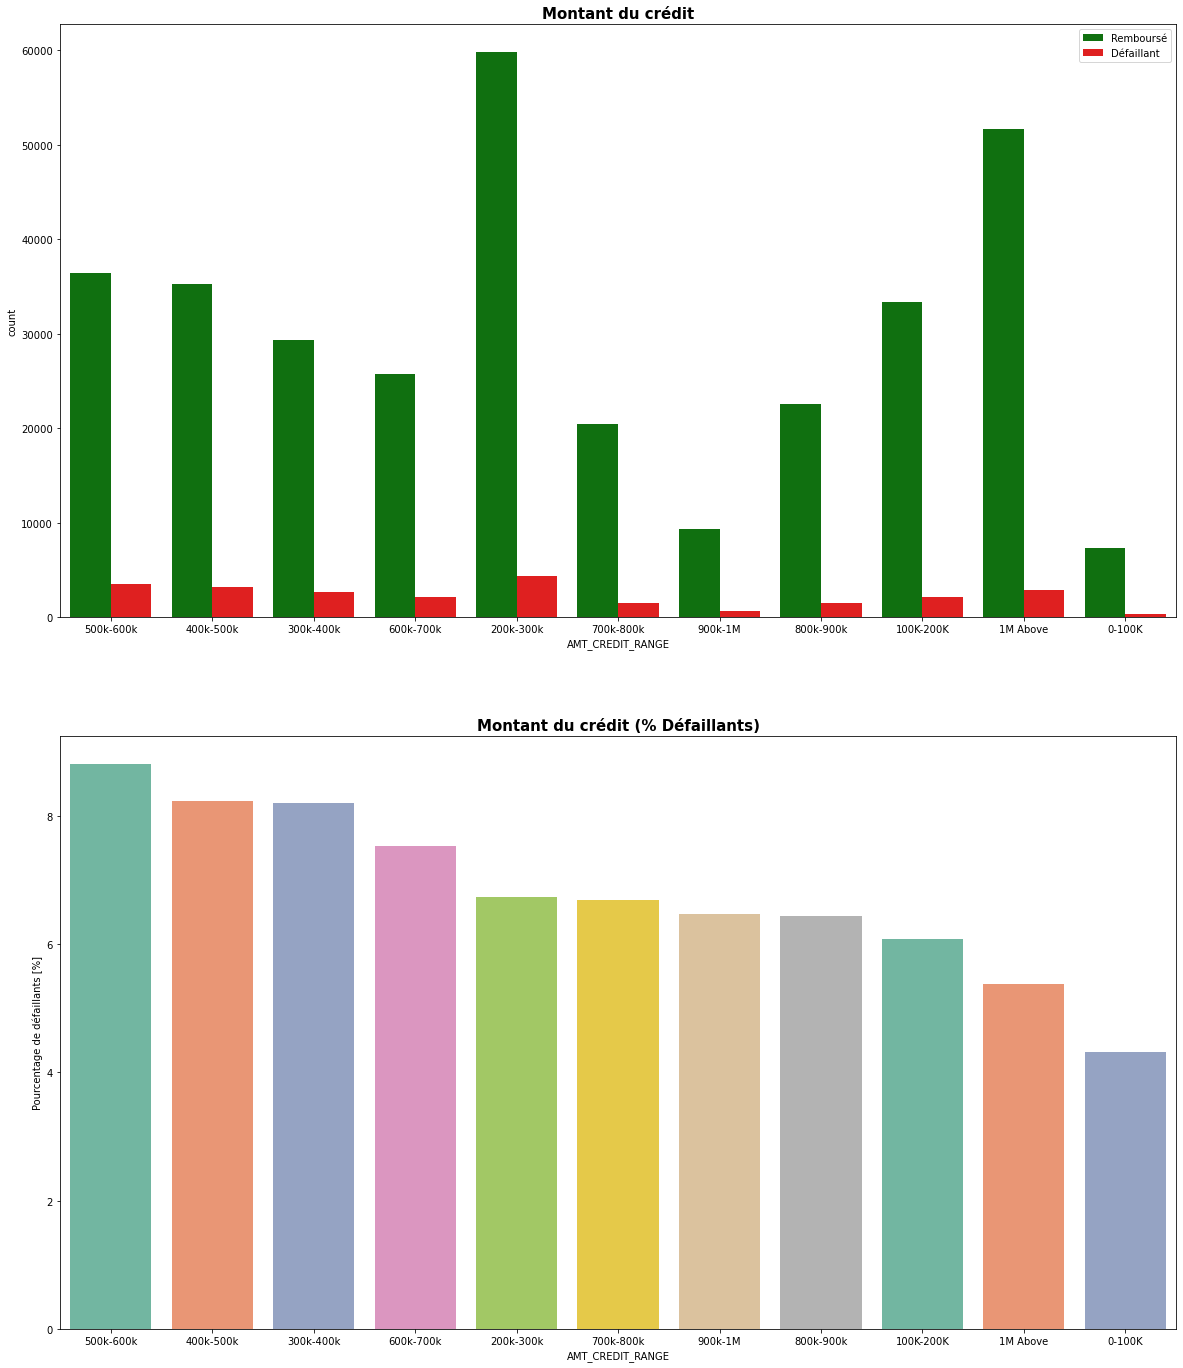

In [379]:
univariate_categorical(applicationDF, 'AMT_CREDIT_RANGE', "Montant du crédit",False,False,False)

- Plus de 80 % des prêts accordés sont d'un montant inférieur à 900 000 euros.

- Les personnes qui obtiennent des prêts de 300 à 600 000 euros ont tendance à ne pas rembourser leurs emprunts plus souvent que les autres.

## Corrélations

In [381]:
#Display correlations
print('15 top correlations positives avec TARGET:\n\n', clean_df.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('15 top correlations négatives avec TARGET:\n\n', clean_df.corr()['TARGET'].sort_values().head(15))

15 top correlations positives avec TARGET:

 PREV_NAME_GOODS_CATEGORY_nan_MEAN          NaN
PREV_NAME_PORTFOLIO_nan_MEAN               NaN
PREV_NAME_PRODUCT_TYPE_nan_MEAN            NaN
PREV_CHANNEL_TYPE_nan_MEAN                 NaN
PREV_NAME_SELLER_INDUSTRY_nan_MEAN         NaN
PREV_NAME_YIELD_GROUP_nan_MEAN             NaN
POS_NAME_CONTRACT_STATUS_nan_MEAN          NaN
CC_NAME_CONTRACT_STATUS_Approved_MIN       NaN
CC_NAME_CONTRACT_STATUS_Refused_MIN        NaN
CC_NAME_CONTRACT_STATUS_Sentproposal_MIN   NaN
CC_NAME_CONTRACT_STATUS_nan_MIN            NaN
CC_NAME_CONTRACT_STATUS_nan_MAX            NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN           NaN
CC_NAME_CONTRACT_STATUS_nan_SUM            NaN
CC_NAME_CONTRACT_STATUS_nan_VAR            NaN
Name: TARGET, dtype: float64
--------------------------
15 top correlations négatives avec TARGET:

 EXT_SOURCE_2                              -0.149737
EXT_SOURCE_3                              -0.142344
EXT_SOURCE_1                              -0.

Les 3 variables présentant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe". Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de notation cumulative réalisée à partir de nombreuses sources de données.

Jetons un coup d'œil à ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

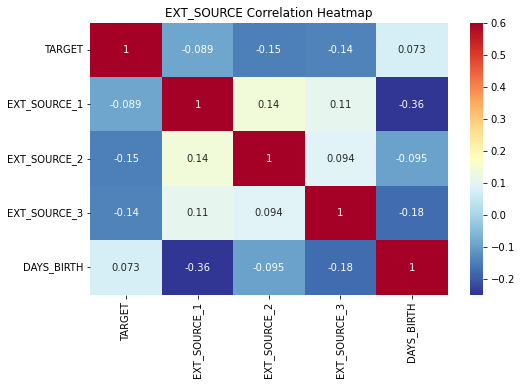

In [382]:
#Heatmap of correlations
plt.figure(figsize = (8,5))
sns.heatmap(clean_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
plt.show()

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de la EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

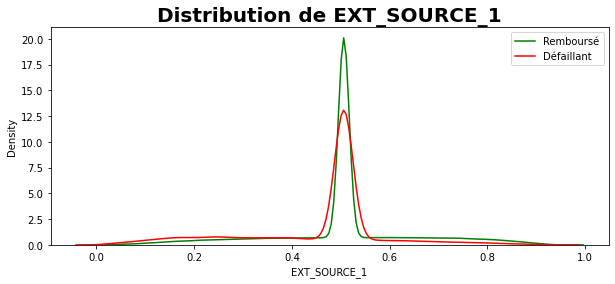

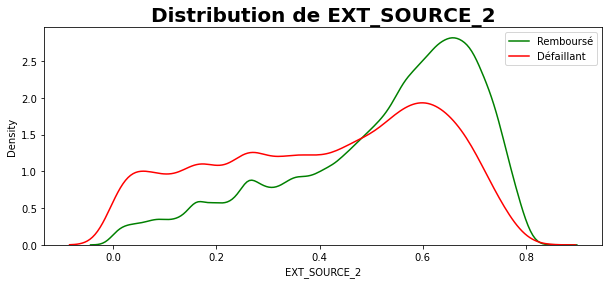

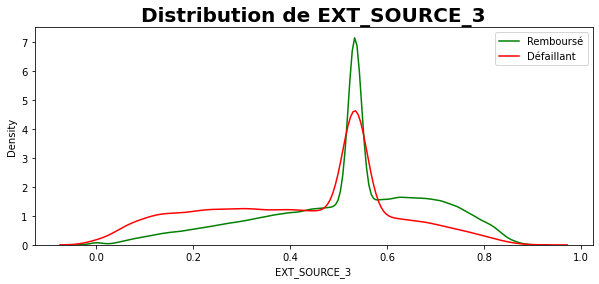

In [384]:
plot_distribution(clean_df,'EXT_SOURCE_1', "Distribution de EXT_SOURCE_1")
plot_distribution(clean_df,'EXT_SOURCE_2', "Distribution de EXT_SOURCE_2")
plot_distribution(clean_df,'EXT_SOURCE_3', "Distribution de EXT_SOURCE_3")

Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt.ces variables seront tout de même utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt à temps

## MODELISATION

### Modèles candidats

Afin de modéliser au mieux notre problème, nous allons comparer les performances de 3 algorithmes :

- Régression Logistique
- RandomForestClassifier
- Light Gradient Boosting Machine

Leurs performances vont être comparées à celles d'une baseline naïve, une instance de la classe DummyClassifier de la librairie Pandas, instantiée avec la stratégie “most_frequent”, c’est-à-dire prédisant systématiquement la classe la plus fréquente.

Nous évaluerons les modèles candidats à l'aide d'une validation croisée (5 folds) et optimisation des hyperparamètres via GridSearch.

### Métriques d'évaluation

Il s'agit d'un problème de classification binaire déséquilibrée.

Nous allons évaluer les modèles à l'aide la métrique suivante:

AUC : plus l'AUC est élevée, plus le modèle est capable de prédire les 0 comme 0 et les 1 comme 1.
Stratégies de gestion du déséquilibre des données



3 approches sont possibles dans ce cas :

- Undersampling : supprimer des observations de la classe majoritaire afin de rééquilibrer le jeu de données
- Oversampling : répéter des observations de la classe minoritaire afin de rééquilibrer le jeu de données
- Weight_balanced : indiquer au modèle le déséquilibre afin qu'il en tienne compte directement
Nous allons utiliser ces 3 approches et comparer les résultats pour l'ensemble des modèles.

In [385]:
train_df = clean_df[clean_df['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
test_df = clean_df[clean_df['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]
test_df = test_df.drop("TARGET", axis=1)

In [386]:
print("train_df shape :", train_df.shape)
print("train_df shape :", test_df.shape)

train_df shape : (307507, 799)
train_df shape : (48744, 798)


In [387]:
# On sauvegarde le dataframe test_df après feature engeniering
# Il ne nous servira pas pour la modélisation mais sera utilisé pour 
# les prédiction sur le dashbord qui sera réalisé par la suite
test_df.to_csv(path+'/test_df.csv')

Nous allons pour la suite essentiellement utiliser le dataframe train_df. En effet, nous avons besoin des données où la variable TARGET en renseignée pour entrainer et tester les différents modèles.

Le jeu de données (train_df) va donc être séparé entre données d'entraînement et données de test.

L'analyse exploratoire ayant fait ressortir un important déséquilibre des classes dans TARGET, nous devons veiller à maintenir ces proportions dans nos nouveaux jeux.

In [393]:
from sklearn.model_selection import train_test_split
Y = train_df["TARGET"]
X = train_df.drop("TARGET", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.3, random_state=42)


print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 92252 lignes,
Test: 215255 lignes.



In [394]:
X.shape

(307507, 798)

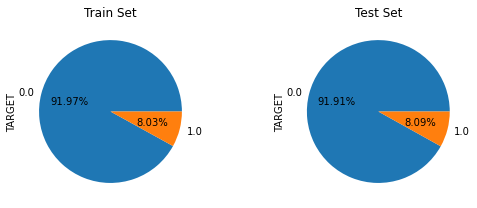

In [395]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

Nous allons prétraiter les données en :

- remplissant les valeurs manquantes (imputation)
- normalisant les features (mise à l'échelle des features).

In [ ]:
Modelisation naive

In [396]:
dc = DummyClassifier()
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
dc.fit(X_train_scaled, y_train)
roc_auc = roc_auc_score(y_test, dc.predict_proba(X_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dc.predict(X_test_scaled)))

AUC : 0.5000


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    197840
         1.0       0.00      0.00      0.00     17415

    accuracy                           0.92    215255
   macro avg       0.46      0.50      0.48    215255
weighted avg       0.84      0.92      0.88    215255



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [46]:
def define_pipeline(classifier):
    '''This function will make a standardisation and oversampling operations
    for a classifier.'''
    
    pipe = Pipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', classifier]])
    return pipe

In [407]:
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier


classifiers = {   'DummyClassifier': DummyClassifier(),
                  'Logistic Regression': LogisticRegression(),
                  'GaussianNB': GaussianNB(),
                  'Random Forest': RandomForestClassifier(),
                  'Xgboost': XGBClassifier(),
                  'AdaBoostClassifier':AdaBoostClassifier(),
                  'Multi-layer Perceptron': MLPClassifier(),
                  'LGBM': LGBMClassifier(),
              }

In [410]:
from sklearn.model_selection import cross_val_score
def results_auc(classifiers):
    '''This function calculates the AUC scores of the different classification models
    through cross-validation on the training set.'''
    
    stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    results = {} 
    for name_clf, clf in classifiers.items():
        print(name_clf)
        model = define_pipeline(clf)
        results[name_clf]= cross_val_score(model, X_train, y_train,
                                          scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)
    return pd.DataFrame(results)

In [411]:
df_results = results_auc(classifiers)
df_results_mean = pd.DataFrame({"Model": [col for col in df_results.columns],
                                "AUC":[df_results[i].mean() for i in df_results.columns]})

DummyClassifier
Logistic Regression


/Users/felixganga/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/felixganga/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

GaussianNB
Random Forest
Xgboost
AdaBoostClassifier
Multi-layer Perceptron


/Users/felixganga/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


LGBM


In [446]:
df_results

,DummyClassifier,Logistic Regression,GaussianNB,Random Forest,Xgboost,AdaBoostClassifier,Multi-layer Perceptron,LGBM
0,0.5,0.765576,0.519514,0.713818,0.753957,0.696937,0.646509,0.770261
1,0.5,0.768039,0.525386,0.709654,0.754157,0.694652,0.651713,0.771464
2,0.5,0.755818,0.528755,0.700303,0.743134,0.693664,0.629605,0.763174


In [414]:
df_results_mean

,Model,AUC
0,DummyClassifier,0.500000
1,Logistic Regression,0.763144
2,GaussianNB,0.524551
3,Random Forest,0.707925
4,Xgboost,0.750416
5,AdaBoostClassifier,0.695084
6,Multi-layer Perceptron,0.642609
7,LGBM,0.768300


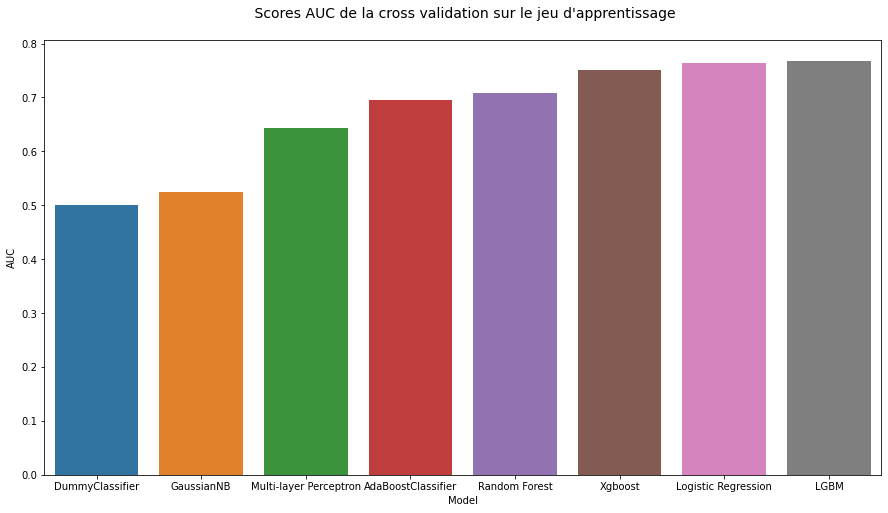

In [412]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x="Model",y="AUC",data=df_results_mean,order=df_results_mean.sort_values('AUC').Model)
title=plt.title(" Scores AUC de la cross validation sur le jeu d'apprentissage" "\n", fontsize=14)

### Feature Selection - Recursive Feature Elimination

In [434]:
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

Fitting estimator with 798 features.
Fitting estimator with 793 features.
Fitting estimator with 788 features.
Fitting estimator with 783 features.
Fitting estimator with 778 features.
Fitting estimator with 773 features.
Fitting estimator with 768 features.
Fitting estimator with 763 features.
Fitting estimator with 758 features.
Fitting estimator with 753 features.
Fitting estimator with 748 features.
Fitting estimator with 743 features.
Fitting estimator with 738 features.
Fitting estimator with 733 features.
Fitting estimator with 728 features.
Fitting estimator with 723 features.
Fitting estimator with 718 features.
Fitting estimator with 713 features.
Fitting estimator with 708 features.
Fitting estimator with 703 features.
Fitting estimator with 698 features.
Fitting estimator with 693 features.
Fitting estimator with 688 features.
Fitting estimator with 683 features.
Fitting estimator with 678 features.
Fitting estimator with 673 features.
Fitting estimator with 668 features.
F

Fitting estimator with 798 features.
Fitting estimator with 793 features.
Fitting estimator with 788 features.
Fitting estimator with 783 features.
Fitting estimator with 778 features.
Fitting estimator with 773 features.
Fitting estimator with 768 features.
Fitting estimator with 763 features.
Fitting estimator with 758 features.
Fitting estimator with 753 features.
Fitting estimator with 748 features.
Fitting estimator with 743 features.
Fitting estimator with 738 features.
Fitting estimator with 733 features.
Fitting estimator with 728 features.
Fitting estimator with 723 features.
Fitting estimator with 718 features.
Fitting estimator with 713 features.
Fitting estimator with 708 features.
Fitting estimator with 703 features.
Fitting estimator with 698 features.
Fitting estimator with 693 features.
Fitting estimator with 688 features.
Fitting estimator with 683 features.
Fitting estimator with 678 features.
Fitting estimator with 673 features.
Fitting estimator with 668 features.
F

Fitting estimator with 663 features.
Fitting estimator with 658 features.
Fitting estimator with 653 features.
Fitting estimator with 648 features.
Fitting estimator with 643 features.
Fitting estimator with 638 features.
Fitting estimator with 633 features.
Fitting estimator with 628 features.
Fitting estimator with 623 features.
Fitting estimator with 618 features.
Fitting estimator with 613 features.
Fitting estimator with 608 features.
Fitting estimator with 603 features.
Fitting estimator with 598 features.
Fitting estimator with 593 features.
Fitting estimator with 588 features.
Fitting estimator with 583 features.
Fitting estimator with 578 features.
Fitting estimator with 573 features.
Fitting estimator with 568 features.
Fitting estimator with 563 features.
Fitting estimator with 558 features.
Fitting estimator with 553 features.
Fitting estimator with 548 features.
Fitting estimator with 543 features.
Fitting estimator with 538 features.
Fitting estimator with 533 features.
F

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
      scoring='roc_auc', step=5, verbose=2)

In [435]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 178


In [437]:
X_rfecv = X.loc[:, X.columns[rfecv.get_support()]]
X_rfecv = X_rfecv.merge(Y, left_index=True, right_index=True)
X_rfecv.shape

(307507, 179)

In [3]:
X_rfecv.to_csv('X_rfecv.csv',index = False)

NameError: name 'X_rfecv' is not defined

In [3]:
X_rfecv = pd.read_csv("X_rfecv.csv")

Le jeu de données étant relativement important, nous allons utiliser un sampling des données.

In [4]:
# Sampling
data = X_rfecv.sample(100000, random_state=42)
data=data.drop(columns=['Unnamed: 0'])
X =  data.drop(columns=['TARGET'])
y =  data.TARGET

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Paramettrage des algorithms d'évaluation

In [6]:
LGBM_params = {
    
    'classifier__n_estimators' : [100,200,300,400,500],
    'classifier__learning_rate' : [0.001, 0.03],
    'classifier__max_depth': [ 3, 7, 1],
    'classifier__subsample': [0.60, 0.95],
    'classifier__colsample_bytree': [0.60, 0.95],
    'classifier__reg_lambda': [ 1, 20]
    }


In [24]:
def run_grid_search(X_train,y_train, model, paramaters_dict):
    stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
  
    m_grid_cv = Pipeline([
                        ('grid_search_ml', GridSearchCV(
                            model,
                            param_grid=paramaters_dict,
                            cv=stratified_kfold,
                            error_score='raise',
                            scoring='roc_auc',
                            refit='roc_auc',
                            return_train_score = True,
                            n_jobs = -1))])
    
    
    fit_model = m_grid_cv.fit(X_train, y_train)
    
    df_results = pd.DataFrame.from_dict(fit_model.named_steps['grid_search_ml'].cv_results_)
    best_roc_auc= fit_model.named_steps['grid_search_ml'].best_score_
    best_params= fit_model.named_steps['grid_search_ml'].best_params_
        
    print("Meilleur score ROC_AUC : {}\nMeilleurs paramètres : {}"\
        .format(round(best_roc_auc,2),best_params))

In [25]:
run_grid_search(X_train,y_train, LGBMClassifier(), LGBM_params)

[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown paramet

[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown paramet

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown p

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown p

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown p

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown p

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown p

[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown p

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
Meilleur score ROC_AUC : 0.76
Meilleurs paramètres : {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.6}
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: c

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__colsample_bytree
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__subsample
[LightGBM] [Warning] Unknown 

In [94]:
def define_pipeline_new(classifier):
    '''This function will make a standardisation and oversampling operations
    for a classifier.'''
    
    pipe = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', classifier]])
    return pipe

In [95]:
lgb_model = define_pipeline_new(LGBMClassifier(colsample_bytree=0.6, learning_rate=0.001,
                     max_depth=5, n_estimators=100, subsample=0.6)).fit(X_train, y_train)


In [96]:
lgb_model

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier',
                 LGBMClassifier(colsample_bytree=0.6, learning_rate=0.001,
                                max_depth=5, subsample=0.6)]])

Le modèle final doit pouvoir déterminer une classe 0 ou 1, ce qui implique de déterminer le seuil à partir duquel la proba calculée se transforme en classe 1 (pour un predict le seuil par défaut est 0.5). Une possibilité serait d’optimiser ce seuil en se basant sur la mesure « technique » du f1 score, mais ne prend pas en compte le contexte « métier »

La problématique « métier » est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé).

Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte

Il est attendu de mettre en œuvre une approche simple qui consiste, une fois le modèle choisi et les hyperparamètres optimisés finement d’un point de vue technique via l’AUC (CF étape précédente), de calculer une fonction de coût métier de type 10*FN + FP (où FN = nombre de FN dans la matrice de confusion pour un seuil donné, FP = nombre de FP) et de trouver son minimum pour un seuil donné.

Une possibilité de fonction métier adaptée au projet est la fonction fbeta_score de sklearn, qui permet d’attribuer plus de poids à la minimisation des FN à travers la pondération du paramètre beta

In [117]:
def Ind_bank(y_true, y_pred, fn_value=10, fp_value=1, tp_value=0, tn_value=0):

    # Matrice de Confusion
    tp,tn,fp,fn= confusion_matrix(y_true, y_pred).ravel()

    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation


In [118]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}


In [89]:
def optim_score(params):
    '''Optim_score function to be minimized. 
    Hyperopt will seek to minimize the loss returned by this function'''
    
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'num_leaves': int(params['num_leaves']),
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= define_pipeline(LGBMClassifier(**params))
    cv = StratifiedKFold(5)
    
    y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
    score = Ind_bank(y_train, y_pred)
    
    return {'loss': score, 'params': params, 'status': STATUS_OK}

In [119]:
def optim_score(params):
    '''Optim_score function to be minimized. 
    Hyperopt will seek to minimize the loss returned by this function'''
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= define_pipeline_new(LGBMClassifier(**params))
    cv = StratifiedKFold(5)
    
    y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
    score = Ind_bank(y_train, y_pred)
    
    return {'loss': score, 'params': params, 'status': STATUS_OK}

In [120]:
best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

100%|█████████| 10/10 [08:39<00:00, 51.97s/trial, best loss: 0.9786746566088899]


In [121]:
best

{'colsample_bytree': 0.7511378706577355,
 'learning_rate': 0.0031405962529210936,
 'max_depth': 3.0,
 'n_estimators': 200.0,
 'reg_lambda': 19.68870720056809,
 'subsample': 0.8581805688026153}

In [122]:
model = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],           
    colsample_bytree=best['colsample_bytree'],
    #num_leaves=int(best['num_leaves']),
    #reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda']
)
lgbm = define_pipeline_new(model)
lgbm_optimise= lgbm.fit(X_train, y_train)

In [142]:
lgbm.to_csv('lgbm.csv',index = False)
lgbm_optimise.to_csv('lgbm_optimise.csv',index = False)

AttributeError: 'Pipeline' object has no attribute 'to_csv'

In [104]:
best['solvability_threshold']

KeyError: 'solvability_threshold'

In [123]:
roc_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)
print(classification_report(y_test, lgb_model.predict(X_test)))

AUC : 0.680067
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     27644
         1.0       0.20      0.08      0.12      2356

    accuracy                           0.90     30000
   macro avg       0.56      0.53      0.53     30000
weighted avg       0.87      0.90      0.88     30000



# Matrice de confusion et roc curve 

In [124]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of an sklearn Confusion Matrix using 
    a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(18,13))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')

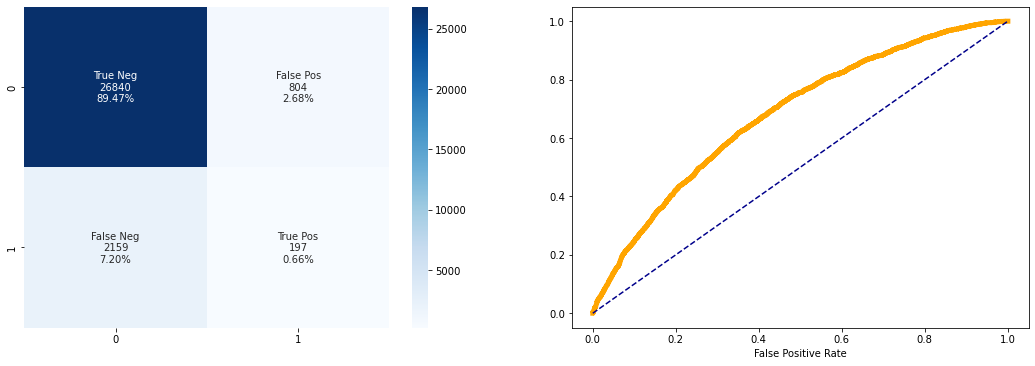

In [125]:
cf_matrix_roc_auc(lgb_model, y_test, lgb_model.predict(X_test), lgb_model.predict_proba(X_test)[:,1])

In [ ]:
pour le modéle optimiser avec la fct de cout meter c'est la mm chose 

In [126]:
roc_auc = roc_auc_score(y_test, lgbm_optimise.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)
print(classification_report(y_test, lgbm_optimise.predict(X_test)))

AUC : 0.674213
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     27644
         1.0       0.20      0.17      0.18      2356

    accuracy                           0.88     30000
   macro avg       0.56      0.55      0.56     30000
weighted avg       0.87      0.88      0.88     30000



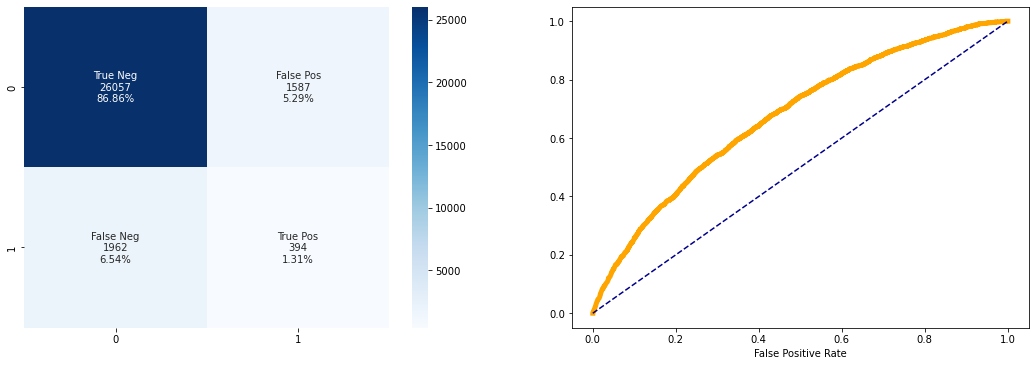

In [127]:
cf_matrix_roc_auc(lgbm_optimise, y_test, lgbm_optimise.predict(X_test), lgbm_optimise.predict_proba(X_test)[:,1])

In [146]:
import pickle
pickle_out = open("lgbm.pkl","wb")
pickle.dump(lgbm_optimise, pickle_out)
pickle_out.close()

### Interprétabilité

Nous allons utiliser la librairie SHAP pour calculer la feature importance globale afin de connaitre d'une manière générale les principales features qui contribuent à l'élaboration du modèle.

- features importance des prédictions faites par le modèle sur xtest

In [128]:
def plot_feature_importances(model):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        model: the model
        
    Returns:
        shows a plot of the 20 most importance features
    """

    indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_train.columns[indices[i]])

    plt.figure(figsize=(15, 8))
    ax=sns.barplot(y=features, x=model.feature_importances_[indices[range(20)]], color=("orange"))
    title=plt.title("Feature Importance Globale" "\n", fontsize=22)

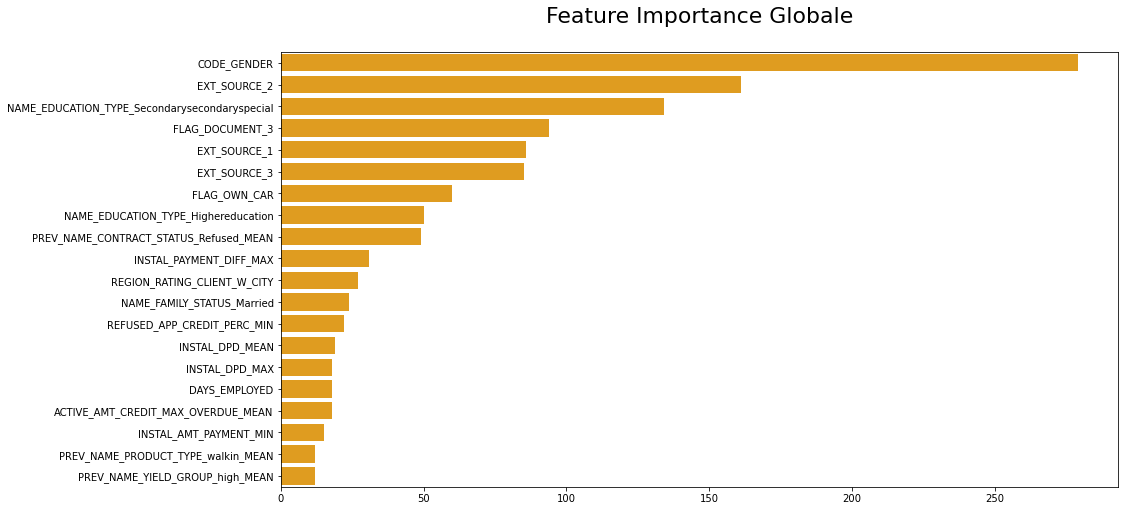

In [129]:
plot_feature_importances(lgbm_optimise[-1])

In [133]:
lgbm_explainer = shap.TreeExplainer(lgbm[-1])

In [137]:
X_test_scaled

array([[0.00000000e+00, 0.00000000e+00, 3.20454869e-03, ...,
        2.15357696e-03, 2.00896605e-04, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.12717019e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 5.50120603e-04, ...,
        2.15357696e-03, 2.00896605e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.00000000e+00, 1.51186991e-03, ...,
        2.15357696e-03, 2.00896605e-04, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.51186991e-03, ...,
        2.07381485e-03, 2.83891489e-04, 9.66663905e-04],
       [0.00000000e+00, 1.00000000e+00, 1.31952005e-03, ...,
        2.15357696e-03, 2.00896605e-04, 0.00000000e+00]])

In [149]:
X_test_scaled = lgbm[1].transform(X_test.sample(1000, random_state=42))
shap_values = explainer.shap_values(X_test_scaled)

NameError: name 'explainer' is not defined

In [ ]:
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X_train.columns)

In [ ]:
X_test_transformed = pd.DataFrame(lgbm[:2].transform(X_test),
                          columns=X_test.columns,
                          index=X_test.index)

lime1 = LimeTabularExplainer(X_test_transformed,
                             feature_names=X_test.columns,
                             class_names=["Solvable", "Non Solvable"],
                             discretize_continuous=False)
                            

exp = lime1.explain_instance(X_test_transformed.iloc[900],
                             lgbm.predict_proba,
                             num_samples=100)

In [ ]:
X_test_transformed.index[900]

In [ ]:
exp.show_in_notebook(show_table=False)

exp.as_pyplot_figure()
plt.tight_layout()

In [111]:
import shap
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(emiss_LGBM_model)
shap_values = explainer.shap_values(X_importance)

NameError: name 'emiss_LGBM_model' is not defined

In [ ]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

In [ ]:
# compute SHAP values

explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)